# Visualizing registration experiment runs

Plot results from the registration runs with random initializations.

To run the registration experiment, run the following in the home directory:

```python experiments/registration/reg.py --n_drrs=1000```

In [1]:
%matplotlib inline

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

from src import read_dicom, DRR
from src.visualization import plot_drr

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
colors = {True: "#e7298a", False: "#7570b3"}

def converged(df):
    return df["loss"].iloc[-1] <= -0.999

694/1000 runs achieved convergence in 3.97±1.64s on average


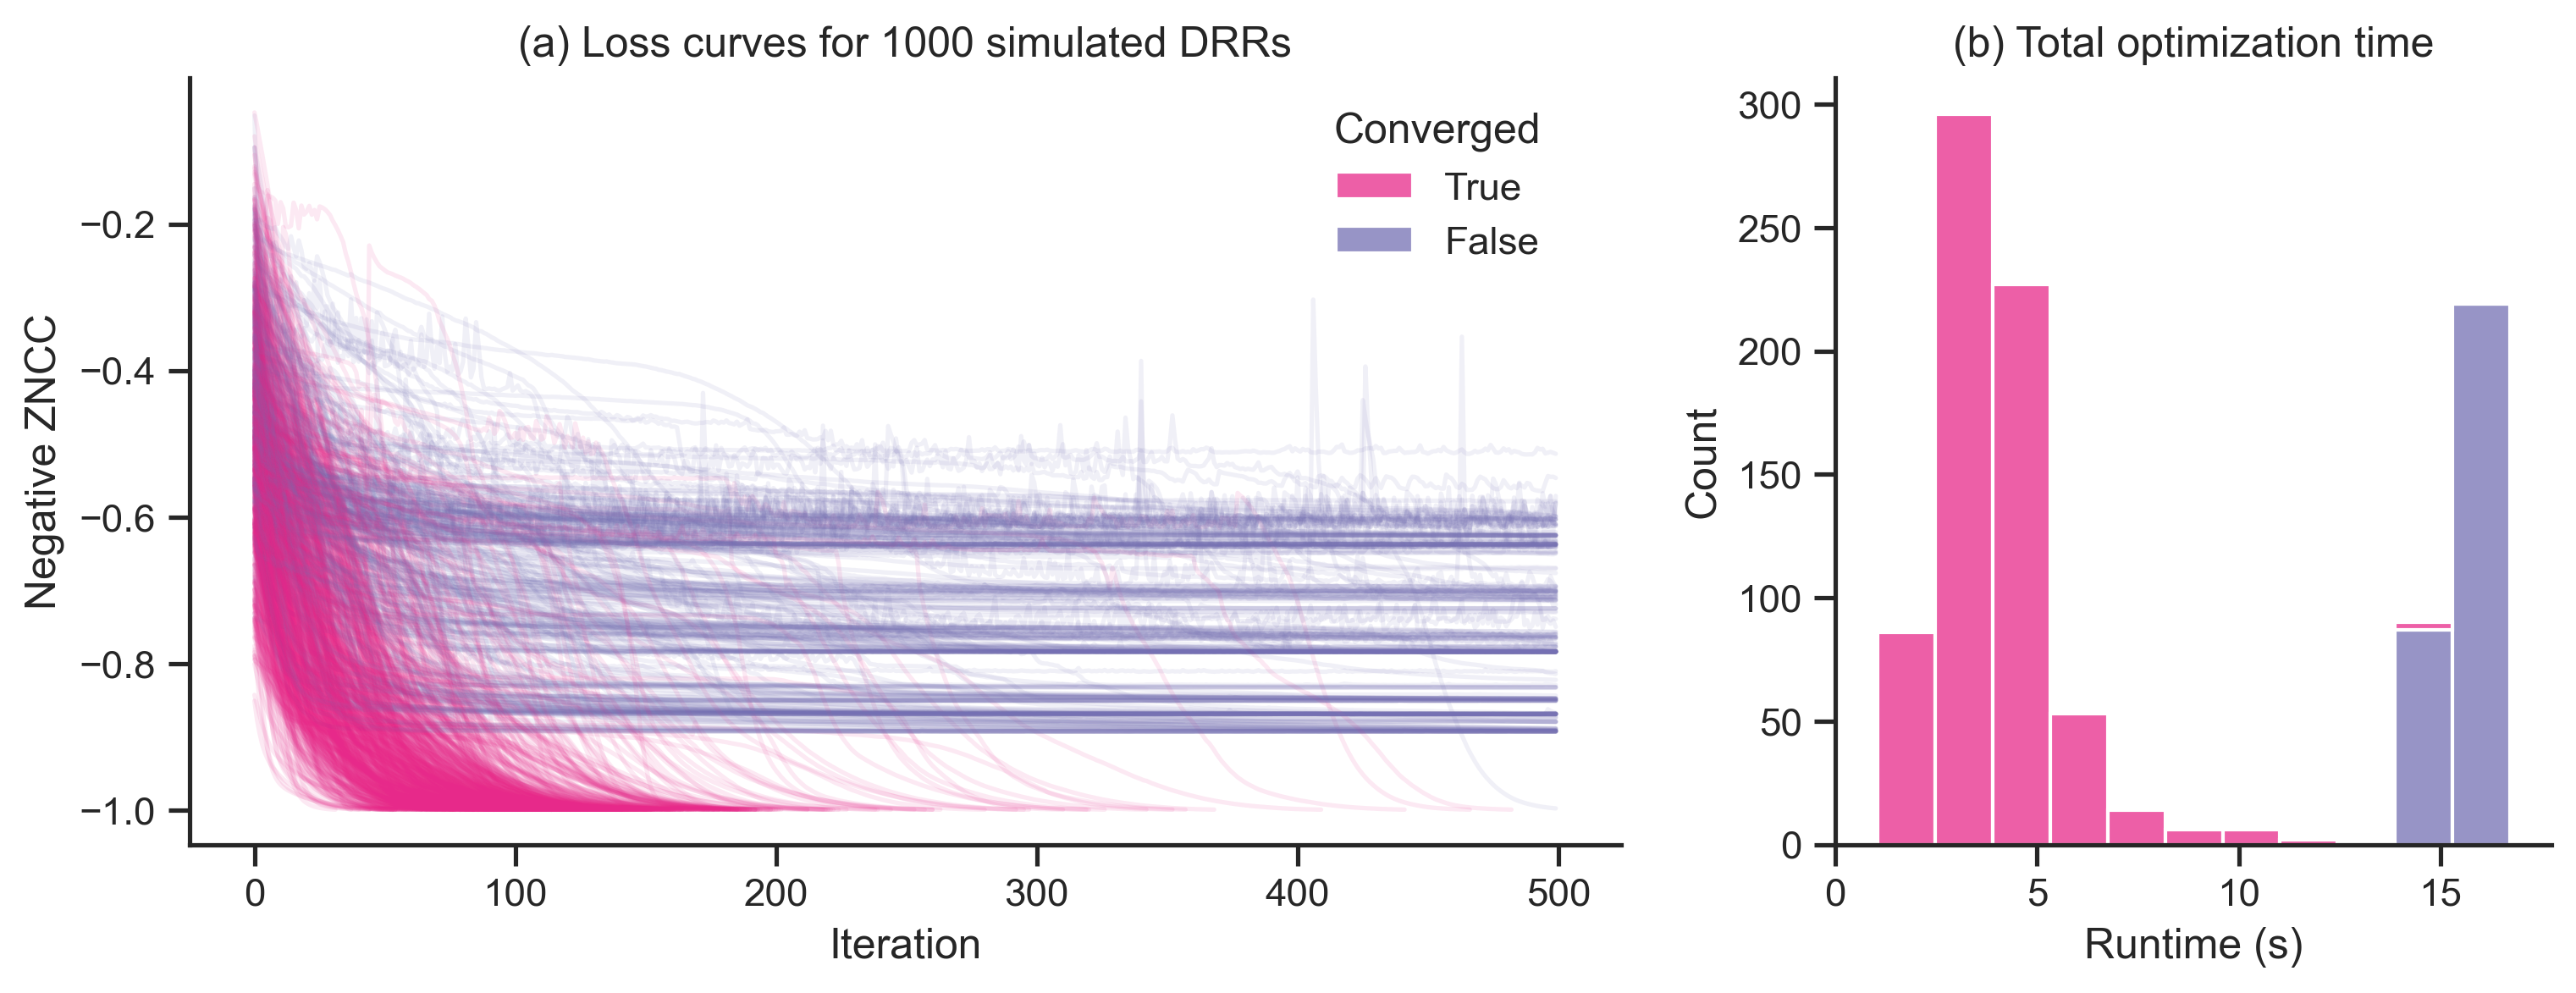

In [3]:
fig = plt.figure(dpi=300, figsize=plt.figaspect(1/3))
gs = gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1], figure=fig)
ax_plot = plt.subplot(gs[0])
ax_hist = plt.subplot(gs[1])

# Plot the training trajectories
dfs = []
kwargs = {"alpha": 0.1, "lw": 1.25}
for file in Path("tmp").glob("*.csv"):
    df = pd.read_csv(file)
    df["runtime"] = df["time"].cumsum()
    df["converged"] = converged(df)
    color = colors[converged(df)]
    ax_plot.plot(df["itr"], df["loss"], color, **kwargs)
    dfs.append(df.iloc[-1])
ax_plot.set(xlabel="Iteration", ylabel="Negative ZNCC", title=f"(a) Loss curves for {len(dfs)} simulated DRRs")

# Plot the convergence timing histogram
df = pd.concat(dfs, axis=1).T.reset_index(drop=True)
sns.histplot(data=df, x="runtime", hue="converged", hue_order=[True, False], multiple="stack", palette=colors, legend=True, ax=ax_hist)
sns.move_legend(ax_hist, loc="upper left", bbox_to_anchor=(-0.75, 1), title="Converged", frameon=False)
ax_hist.set(xlabel="Runtime (s)", xlim=(0, 17.75), title="(b) Total optimization time")

# Get runtime metrics
n_conv = df["converged"].astype(int).sum()
t_conv = df.query("converged == True")["runtime"].mean()
s_conv = df.query("converged == True")["runtime"].std()
print(f"{n_conv}/{len(df)} runs achieved convergence in {t_conv:.2f}±{s_conv:.2f}s on average")
plt.savefig("../../figures/optimization.pdf", bbox_inches="tight")

## Animations

Trying to animate the optimization loop.

In [4]:
from IPython.display import HTML
from matplotlib.animation import ArtistAnimation
from tqdm import tqdm

In [17]:
# Utility functions for animating DRRs
volume, spacing = read_dicom("../../data/cxr")
drr = DRR(volume, spacing, height=100, delx=5e-2, device="cpu")


def precompute_drrs(df, sdr):
    imgs = []
    for _, row in tqdm(df.iterrows(), desc="Precomputing DRRs", total=len(df)):
        params = row[["theta", "phi", "gamma", "bx", "by", "bz"]].values
        itr = drr(200, *params).detach().cpu().numpy()
        img = ax.imshow(itr, cmap="gray", animated=True)
        imgs.append([img])
    return imgs

Precomputing DRRs: 100%|███████████████████████████████████████████| 123/123 [00:38<00:00,  3.23it/s]


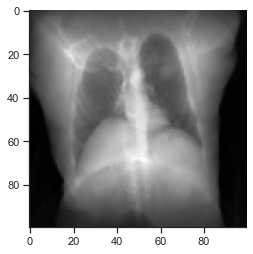

In [19]:
# csvfiles = Path("tmp").glob("*.csv")
# df = pd.read_csv(next(csvfiles))

fig, ax = plt.subplots()
imgs = precompute_drrs(df, sdr=200)
anim = ArtistAnimation(fig, imgs, interval=50, blit=True, repeat_delay=1000)
HTML(anim.to_jshtml())
# plt.show()